In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa
from keras.callbacks import ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam


In [2]:
TRAIN_DIR = '../data/cancerous/training'
TEST_DIR = '../data/cancerous/testing'
VAL_DIR = '../data/cancerous/validation'
# INPUT_WIDTH = 27
# INPUT_HEIGHT = 27

BATCH_SIZE = 128
IMG_SIZE = (32, 32)


train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='bilinear',
                                             label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='bilinear',
                                                  label_mode='categorical'
                                            )

Found 16223 files belonging to 2 classes.
Found 2028 files belonging to 2 classes.
Found 2029 files belonging to 2 classes.


In [3]:
def get_class_name(class_num):
    if class_num == 0:
        return 'non-cancerous'
    elif class_num == 1:
        return 'cancerous'

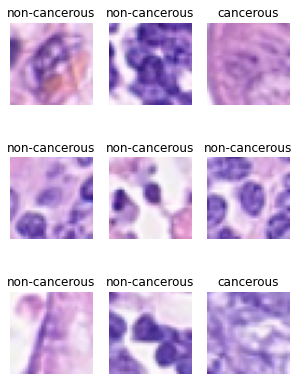

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_name(tf.where(tf.equal(labels[i], 1)).numpy()[0][0]))
        plt.axis("off")

In [5]:
train_dataset.class_names

['0', '1']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

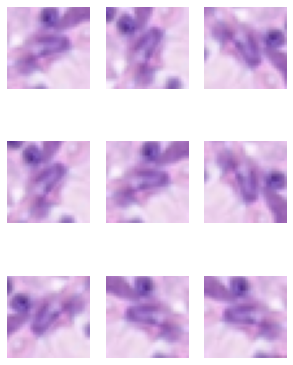

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')

In [9]:
# Create the base model from VGG16 model without pre-trained weights
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [10]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(2)

In [12]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score ,precision_m, recall_m])

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [15]:
len(model.trainable_variables)

28

In [16]:
epochs = 500

loss0, accuracy0, f1_0, precision0, recall0 = model.evaluate(validation_dataset)

16/16 [==============================] - 2s 21ms/step - loss: 0.6930 - accuracy: 0.6514 - f1_score: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


In [17]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.65


In [18]:
import time
start_time = time.time()

In [19]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                   )

Epoch 1/500
127/127 [==============================] - 4s 18ms/step - loss: 0.5611 - accuracy: 0.7102 - f1_score: 0.5764 - precision_m: 0.7573 - recall_m: 0.4982 - val_loss: 0.3793 - val_accuracy: 0.8274 - val_f1_score: 0.8160 - val_precision_m: 0.8522 - val_recall_m: 0.7830
Epoch 2/500
127/127 [==============================] - 2s 14ms/step - loss: 0.3532 - accuracy: 0.8503 - f1_score: 0.8381 - precision_m: 0.8776 - recall_m: 0.8025 - val_loss: 0.3331 - val_accuracy: 0.8624 - val_f1_score: 0.8458 - val_precision_m: 0.8852 - val_recall_m: 0.8101
Epoch 3/500
127/127 [==============================] - 2s 15ms/step - loss: 0.3100 - accuracy: 0.8693 - f1_score: 0.8625 - precision_m: 0.8949 - recall_m: 0.8328 - val_loss: 0.3141 - val_accuracy: 0.8649 - val_f1_score: 0.8651 - val_precision_m: 0.8889 - val_recall_m: 0.8429
Epoch 4/500
127/127 [==============================] - 2s 15ms/step - loss: 0.3021 - accuracy: 0.8731 - f1_score: 0.8643 - precision_m: 0.8951 - recall_m: 0.8358 - val_loss

Epoch 31/500
127/127 [==============================] - 2s 15ms/step - loss: 0.2047 - accuracy: 0.9178 - f1_score: 0.9128 - precision_m: 0.9363 - recall_m: 0.8907 - val_loss: 0.2648 - val_accuracy: 0.9038 - val_f1_score: 0.8969 - val_precision_m: 0.9171 - val_recall_m: 0.8778
Epoch 32/500
127/127 [==============================] - 2s 15ms/step - loss: 0.2091 - accuracy: 0.9171 - f1_score: 0.9099 - precision_m: 0.9346 - recall_m: 0.8867 - val_loss: 0.2433 - val_accuracy: 0.9083 - val_f1_score: 0.9079 - val_precision_m: 0.9301 - val_recall_m: 0.8868
Epoch 33/500
127/127 [==============================] - 2s 15ms/step - loss: 0.2055 - accuracy: 0.9191 - f1_score: 0.9140 - precision_m: 0.9348 - recall_m: 0.8942 - val_loss: 0.2417 - val_accuracy: 0.9073 - val_f1_score: 0.9050 - val_precision_m: 0.9203 - val_recall_m: 0.8904
Epoch 34/500
127/127 [==============================] - 2s 15ms/step - loss: 0.1981 - accuracy: 0.9213 - f1_score: 0.9157 - precision_m: 0.9375 - recall_m: 0.8951 - val_

Epoch 61/500
127/127 [==============================] - 2s 14ms/step - loss: 0.1301 - accuracy: 0.9484 - f1_score: 0.9456 - precision_m: 0.9634 - recall_m: 0.9287 - val_loss: 0.2302 - val_accuracy: 0.9201 - val_f1_score: 0.9171 - val_precision_m: 0.9314 - val_recall_m: 0.9033
Epoch 62/500
127/127 [==============================] - 2s 14ms/step - loss: 0.1324 - accuracy: 0.9504 - f1_score: 0.9472 - precision_m: 0.9612 - recall_m: 0.9338 - val_loss: 0.2744 - val_accuracy: 0.9117 - val_f1_score: 0.9075 - val_precision_m: 0.9196 - val_recall_m: 0.8958
Epoch 63/500
127/127 [==============================] - 2s 14ms/step - loss: 0.1226 - accuracy: 0.9541 - f1_score: 0.9514 - precision_m: 0.9638 - recall_m: 0.9393 - val_loss: 0.2462 - val_accuracy: 0.9162 - val_f1_score: 0.9167 - val_precision_m: 0.9282 - val_recall_m: 0.9056
Epoch 64/500
127/127 [==============================] - 2s 14ms/step - loss: 0.1194 - accuracy: 0.9541 - f1_score: 0.9521 - precision_m: 0.9639 - recall_m: 0.9407 - val_

Epoch 91/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0674 - accuracy: 0.9752 - f1_score: 0.9741 - precision_m: 0.9817 - recall_m: 0.9666 - val_loss: 0.3539 - val_accuracy: 0.9122 - val_f1_score: 0.9125 - val_precision_m: 0.9197 - val_recall_m: 0.9054
Epoch 92/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0757 - accuracy: 0.9718 - f1_score: 0.9703 - precision_m: 0.9779 - recall_m: 0.9628 - val_loss: 0.3042 - val_accuracy: 0.9088 - val_f1_score: 0.9114 - val_precision_m: 0.9226 - val_recall_m: 0.9004
Epoch 93/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0742 - accuracy: 0.9717 - f1_score: 0.9695 - precision_m: 0.9783 - recall_m: 0.9610 - val_loss: 0.3448 - val_accuracy: 0.9152 - val_f1_score: 0.9160 - val_precision_m: 0.9269 - val_recall_m: 0.9054
Epoch 94/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0688 - accuracy: 0.9736 - f1_score: 0.9727 - precision_m: 0.9816 - recall_m: 0.9641 - val_

127/127 [==============================] - 2s 14ms/step - loss: 0.0326 - accuracy: 0.9888 - f1_score: 0.9880 - precision_m: 0.9915 - recall_m: 0.9846 - val_loss: 0.4002 - val_accuracy: 0.9152 - val_f1_score: 0.9123 - val_precision_m: 0.9180 - val_recall_m: 0.9066
Epoch 150/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0284 - accuracy: 0.9891 - f1_score: 0.9893 - precision_m: 0.9922 - recall_m: 0.9864 - val_loss: 0.3910 - val_accuracy: 0.9250 - val_f1_score: 0.9214 - val_precision_m: 0.9291 - val_recall_m: 0.9139
Epoch 151/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0328 - accuracy: 0.9880 - f1_score: 0.9878 - precision_m: 0.9912 - recall_m: 0.9844 - val_loss: 0.4807 - val_accuracy: 0.9117 - val_f1_score: 0.9098 - val_precision_m: 0.9152 - val_recall_m: 0.9044
Epoch 152/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0305 - accuracy: 0.9886 - f1_score: 0.9883 - precision_m: 0.9914 - recall_m: 0.9853 - val_loss: 0.39

127/127 [==============================] - 2s 14ms/step - loss: 0.0155 - accuracy: 0.9944 - f1_score: 0.9940 - precision_m: 0.9957 - recall_m: 0.9924 - val_loss: 0.4694 - val_accuracy: 0.9221 - val_f1_score: 0.9230 - val_precision_m: 0.9289 - val_recall_m: 0.9172
Epoch 208/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0311 - accuracy: 0.9883 - f1_score: 0.9878 - precision_m: 0.9920 - recall_m: 0.9838 - val_loss: 0.3218 - val_accuracy: 0.9255 - val_f1_score: 0.9234 - val_precision_m: 0.9338 - val_recall_m: 0.9133
Epoch 209/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0173 - accuracy: 0.9937 - f1_score: 0.9936 - precision_m: 0.9957 - recall_m: 0.9916 - val_loss: 0.4807 - val_accuracy: 0.9142 - val_f1_score: 0.9160 - val_precision_m: 0.9206 - val_recall_m: 0.9115
Epoch 210/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0170 - accuracy: 0.9936 - f1_score: 0.9934 - precision_m: 0.9954 - recall_m: 0.9914 - val_loss: 0.49

127/127 [==============================] - 2s 15ms/step - loss: 0.0119 - accuracy: 0.9962 - f1_score: 0.9959 - precision_m: 0.9969 - recall_m: 0.9950 - val_loss: 0.6426 - val_accuracy: 0.9191 - val_f1_score: 0.9181 - val_precision_m: 0.9209 - val_recall_m: 0.9154
Epoch 266/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0154 - accuracy: 0.9944 - f1_score: 0.9945 - precision_m: 0.9957 - recall_m: 0.9934 - val_loss: 0.5984 - val_accuracy: 0.9216 - val_f1_score: 0.9208 - val_precision_m: 0.9246 - val_recall_m: 0.9172
Epoch 267/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0170 - accuracy: 0.9943 - f1_score: 0.9939 - precision_m: 0.9951 - recall_m: 0.9926 - val_loss: 0.6058 - val_accuracy: 0.9181 - val_f1_score: 0.9182 - val_precision_m: 0.9235 - val_recall_m: 0.9130
Epoch 268/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0188 - accuracy: 0.9928 - f1_score: 0.9927 - precision_m: 0.9950 - recall_m: 0.9905 - val_loss: 0.55

127/127 [==============================] - 2s 14ms/step - loss: 0.0127 - accuracy: 0.9955 - f1_score: 0.9956 - precision_m: 0.9972 - recall_m: 0.9941 - val_loss: 0.6041 - val_accuracy: 0.9231 - val_f1_score: 0.9232 - val_precision_m: 0.9270 - val_recall_m: 0.9194
Epoch 324/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0117 - accuracy: 0.9958 - f1_score: 0.9957 - precision_m: 0.9966 - recall_m: 0.9948 - val_loss: 0.4559 - val_accuracy: 0.9196 - val_f1_score: 0.9183 - val_precision_m: 0.9261 - val_recall_m: 0.9106
Epoch 325/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0147 - accuracy: 0.9956 - f1_score: 0.9950 - precision_m: 0.9964 - recall_m: 0.9936 - val_loss: 0.4463 - val_accuracy: 0.9241 - val_f1_score: 0.9223 - val_precision_m: 0.9287 - val_recall_m: 0.9161
Epoch 326/500
127/127 [==============================] - 2s 14ms/step - loss: 0.0117 - accuracy: 0.9959 - f1_score: 0.9955 - precision_m: 0.9970 - recall_m: 0.9940 - val_loss: 0.45

127/127 [==============================] - 2s 15ms/step - loss: 0.0096 - accuracy: 0.9967 - f1_score: 0.9966 - precision_m: 0.9974 - recall_m: 0.9957 - val_loss: 0.6419 - val_accuracy: 0.9246 - val_f1_score: 0.9248 - val_precision_m: 0.9271 - val_recall_m: 0.9225
Epoch 382/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0110 - accuracy: 0.9959 - f1_score: 0.9961 - precision_m: 0.9970 - recall_m: 0.9953 - val_loss: 0.5955 - val_accuracy: 0.9231 - val_f1_score: 0.9232 - val_precision_m: 0.9260 - val_recall_m: 0.9205
Epoch 383/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0125 - accuracy: 0.9947 - f1_score: 0.9948 - precision_m: 0.9959 - recall_m: 0.9938 - val_loss: 0.6292 - val_accuracy: 0.9221 - val_f1_score: 0.9212 - val_precision_m: 0.9298 - val_recall_m: 0.9128
Epoch 384/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0132 - accuracy: 0.9951 - f1_score: 0.9949 - precision_m: 0.9967 - recall_m: 0.9932 - val_loss: 0.55

127/127 [==============================] - 2s 15ms/step - loss: 0.0105 - accuracy: 0.9961 - f1_score: 0.9961 - precision_m: 0.9973 - recall_m: 0.9948 - val_loss: 0.6597 - val_accuracy: 0.9201 - val_f1_score: 0.9176 - val_precision_m: 0.9222 - val_recall_m: 0.9131
Epoch 440/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0059 - accuracy: 0.9978 - f1_score: 0.9977 - precision_m: 0.9983 - recall_m: 0.9971 - val_loss: 0.5953 - val_accuracy: 0.9221 - val_f1_score: 0.9201 - val_precision_m: 0.9247 - val_recall_m: 0.9156
Epoch 441/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0064 - accuracy: 0.9979 - f1_score: 0.9978 - precision_m: 0.9984 - recall_m: 0.9972 - val_loss: 0.5480 - val_accuracy: 0.9231 - val_f1_score: 0.9208 - val_precision_m: 0.9267 - val_recall_m: 0.9149
Epoch 442/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0114 - accuracy: 0.9963 - f1_score: 0.9960 - precision_m: 0.9972 - recall_m: 0.9948 - val_loss: 0.51

127/127 [==============================] - 2s 15ms/step - loss: 0.0087 - accuracy: 0.9971 - f1_score: 0.9971 - precision_m: 0.9978 - recall_m: 0.9964 - val_loss: 0.5532 - val_accuracy: 0.9315 - val_f1_score: 0.9326 - val_precision_m: 0.9358 - val_recall_m: 0.9293
Epoch 498/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0053 - accuracy: 0.9980 - f1_score: 0.9977 - precision_m: 0.9984 - recall_m: 0.9971 - val_loss: 0.6259 - val_accuracy: 0.9280 - val_f1_score: 0.9277 - val_precision_m: 0.9318 - val_recall_m: 0.9237
Epoch 499/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0070 - accuracy: 0.9977 - f1_score: 0.9976 - precision_m: 0.9986 - recall_m: 0.9967 - val_loss: 0.5720 - val_accuracy: 0.9250 - val_f1_score: 0.9259 - val_precision_m: 0.9293 - val_recall_m: 0.9224
Epoch 500/500
127/127 [==============================] - 2s 15ms/step - loss: 0.0062 - accuracy: 0.9977 - f1_score: 0.9975 - precision_m: 0.9983 - recall_m: 0.9967 - val_loss: 0.60

In [20]:
print("---  Training time in seconds ---%s " % (time.time() - start_time))

---  Training time in seconds ---943.5045990943909 


In [21]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset)

16/16 [==============================] - 0s 20ms/step - loss: 0.6185 - accuracy: 0.9236 - f1_score: 0.9225 - precision_m: 0.9278 - recall_m: 0.9174


In [22]:
model.save('VGG16-cancerous-classification.hdf5')

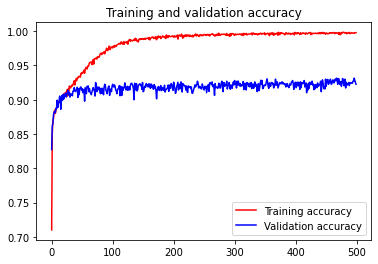

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

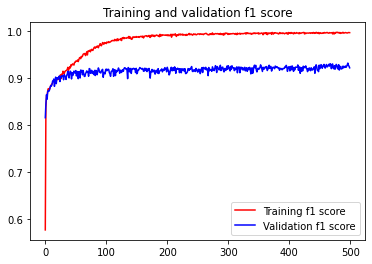

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(len(f1))

plt.plot(epochs, f1, 'r', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend(loc=0)
plt.figure()


plt.show()

In [25]:
# print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test F1 score', f1_score)

Test accuracy: 0.9236077070236206
Test F1 score 0.9225138425827026


In [26]:
print('Max validation accuracy:', max(history.history['val_accuracy']))

Max validation accuracy: 0.9314595460891724


In [27]:
print('Max training accuracy:', max(history.history['accuracy']))

Max training accuracy: 0.9983973503112793


In [28]:
print('Max validation F1 score:', max(history.history['val_f1_score']))

Max validation F1 score: 0.9325635433197021


In [29]:
print('Max training F1 score:', max(history.history['f1_score']))

Max training F1 score: 0.9983991384506226
